In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import seaborn

In [6]:
user_table = pd.read_csv('user_table.csv')
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [15]:
test_result = pd.read_csv('test_results.csv', parse_dates=['timestamp'])
test_result.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [16]:
test_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


# Preprocessing

In [35]:
user_table['user_id'].unique().shape[0]

275616

In [36]:
test_result['user_id'].unique().shape[0]

316800

In [37]:
user_test = test_result.merge(user_table, how = 'left', on = 'user_id')
user_test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [38]:
user_test[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

In [39]:
user_test = user_test[((user_test['test']==0) & (user_test['price']==39)) | ((user_test['test']==1) & (user_test['price']==59))]

In [41]:
user_test['revenue'] = user_test['converted'] * user_test['price']

# Q1

In [42]:
user_test[['test', 'converted']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


In [43]:
user_test[['test', 'revenue']].groupby('test').mean()

,revenue
test,
0,0.776083
1,0.917748


Null Hypothesis: the experiment group has equal or less revenue than the control group



Alternative Hypothesis: the experiment group has more revenue than the control group

In [47]:
control = user_test[user_test['test']== 0]['revenue'].values
experiment = user_test[user_test['test']== 1]['revenue'].values

In [54]:
from scipy.stats import ttest_ind # Two tailed p-value
print(ttest_ind(control, experiment))

Ttest_indResult(statistic=-6.190896693515704, pvalue=5.989596053694189e-10)


Two tailed p-value = 5.908*10^-10, which is less than 0.05; however, we want to perform one-tail test because of null hypothesis; however given two tailed test is already lowwer than 0.05, one tail is even smaller.

p-value def: given the null hypothesis is true, the probability that we could observe what was in our result with our user_test data set is 5.908*10^-10: this value is really small, < 0.05, so we could safely reject the null hypothesis. 

Thus, although the conversion rate for price $59 is lower, the revenue it generates is higher statiscally compared with $39 price.

# Q2

# Device vs. revenue

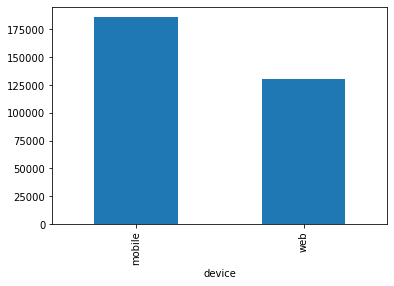

In [65]:
user_test.groupby(['device'])['user_id'].count().plot(kind='bar')
plt.show()

In [66]:
user_test.groupby(['device','test']).agg({'converted':'mean'})

converted
device test           
mobile 0      0.019872
       1      0.016146
web    0      0.019940
       1      0.014744

# Operating System

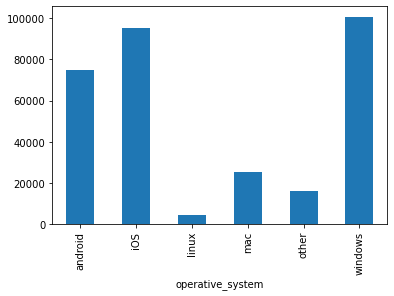

In [67]:
user_test.groupby('operative_system')['user_id'].count().plot(kind='bar')
plt.show()

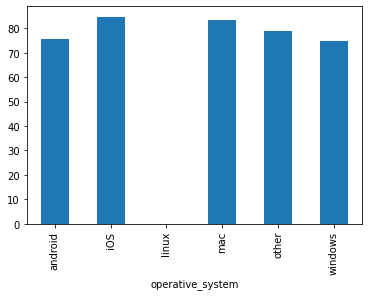

In [72]:
df = user_test.groupby(['operative_system']).apply(lambda x: np.mean(x.loc[x.test==1,'converted'])/np.mean(x.loc[x.test==0,'converted'])*100)
df.plot.bar()

# Source vs Conversion

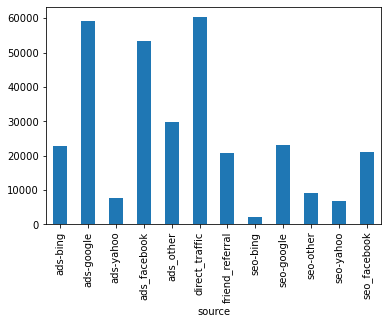

In [69]:
user_test.groupby('source')['user_id'].count().plot(kind='bar')
plt.show()

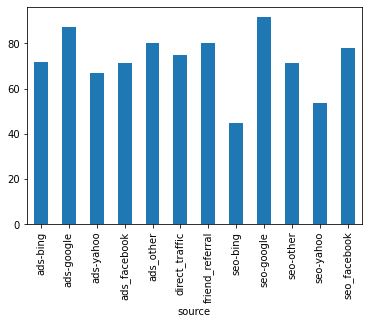

In [73]:
df = user_test.groupby(['source']).apply(lambda x: np.mean(x.loc[x.test==1,'converted'])/np.mean(x.loc[x.test==0,'converted'])*100)
df.plot.bar()

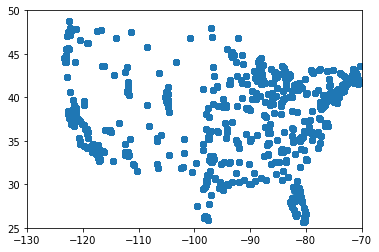

In [79]:
plt.scatter(user_test.loc[user_test['country']=='USA','long'],user_test.loc[user_test['country']=='USA','lat'])
plt.xlim([-130,-70])
plt.ylim([25,50])
plt.show()

In [ ]:
Conversion rate for MAC and IOS users has higher conversion rate and we probably should do more promotion on these two platforms

The Linux system has a lowest conversion rate across all OS, is there a issue on that system?